#### Data Import

In [93]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.2.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

#### Replacing Zeros

In [94]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(7):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

#### Defining get_correlated and creating dictionare with data

In [95]:
corr_matrix = data.corr()
target_columns = [
    "Al2O3.7",
    "Fe2O3.7",
    "CS-C.7",
    "Carbono.7",
]

datasets = {}
def get_correlated_features(target_columns, threshold, datasets):
    for target in target_columns:
        correlated_features = corr_matrix[target][abs(corr_matrix[target]) > threshold].index.tolist()
        datasets[target] = data[correlated_features].drop(columns=[target])
        print(f"Correlated features for {target}: {correlated_features}")

get_correlated_features(target_columns, 0.1, datasets)

Correlated features for Al2O3.7: ['Al2O3.0', 'Fe2O3.0', 'L.0', 'a.0', '%.0', 'Al2O3.1', 'Fe2O3.1', '>63mm.1', 'A.A..1', 'L.1', 'a.1', '%.1', 'Al2O3.2', 'Fe2O3.2', '>63mm.2', 'CS-C.2', 'Carbono.2', 'L.2', 'Al2O3.3', 'Fe2O3.3', '>63mm.3', '>45mm.3', 'CS-C.3', 'RMS.3', 'A.A..3', 'Carbono.3', 'L.3', 'a.3', 'Al2O3.4', 'Fe2O3.4', '>63mm.4', '>45mm.4', 'CS-C.4', 'RMS.4', 'A.A..4', 'Carbono.4', 'L.4', 'a.4', '%.4', 'Al2O3.5', 'Fe2O3.5', '>63mm.5', '>45mm.5', 'CS-C.5', 'RMS.5', 'A.A..5', 'Carbono.5', 'L.5', 'a.5', '%.5', 'Al2O3.6', 'Fe2O3.6', '>63mm.6', '>45mm.6', 'CS-C.6', 'RMS.6', 'A.A..6', 'Carbono.6', 'L.6', 'a.6', '%.6', 'Al2O3.7', 'CS-C.7']
Correlated features for Fe2O3.7: ['Fe2O3.0', 'L.0', 'a.0', 'Al2O3.1', 'Fe2O3.1', '>63mm.1', '>45mm.1', 'CS-C.1', 'RMS.1', 'A.A..1', 'L.1', 'a.1', '%.1', 'L.2', 'a.2', 'Fe2O3.4', 'RMS.4', 'A.A..4', 'a.4', '%.4', 'A.A..5', 'a.5', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']
Correlated features for CS-C.7: ['Al2O3.0', 'Carbono.0', '%.0', 'Al2O3.1', '>45mm.2', 'A.A..

In [96]:
X = {}
y = {}
for target in target_columns:
    X[target] = datasets[target]
    y[target] = data[target]
    print(f"X[{target}]: {X[target].shape}, y[{target}]: {y[target].shape}")
    

X[Al2O3.7]: (230, 62), y[Al2O3.7]: (230,)
X[Fe2O3.7]: (230, 24), y[Fe2O3.7]: (230,)
X[CS-C.7]: (230, 53), y[CS-C.7]: (230,)
X[Carbono.7]: (230, 25), y[Carbono.7]: (230,)


In [97]:
def plot_all_preds(plot_data, title_suffix=''):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for i, ax in enumerate(axs.ravel()):

        name, y_true, y_pred = plot_data[i]
        ax.plot(y_true, label='Actual', color='blue')
        ax.plot(y_pred, label='Predicted', linestyle='--', color='orange')
        ax.set_title(f'{name}: Actual vs Predicted')
        #ax.set_xlabel('Sample Index')
        ax.set_ylabel(name)
        ax.grid(True)
        ax.legend()

    fig.suptitle(f'Actual vs Predicted ({title_suffix})', fontsize=16)
    plt.show()

In [98]:
def plot_pred(y_data, y_pred):
    import matplotlib.pyplot as plt
    y_actual_sorted = y_data.reset_index(drop=True)
    y_pred_sorted = pd.Series(y_pred).reset_index(drop=True)
    plt.figure(figsize=(10, 4))
    plt.plot(y_actual_sorted, label='Actual', linewidth=2)
    plt.plot(y_pred_sorted, label='Predicted', linewidth=2, linestyle='--')
    plt.title(f'Actual vs Predicted Values for {y_data.name[:-2]}')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{y_data.name[:-2]} Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Defining training function

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
 
all_results = []


def train_model(X, y, features):
    results = []
    plot_data = []
    for target in target_columns:
        X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)
    
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Features': features,  
            'Target': target[:-2],
            'MAE': mae,
            'MSE': mse,
            'R2': r2
        })
        
        print(f"\nTraining model for target: {target[:-2]}")
        print(f"   MAE: {mae:.4f}")
        print(f"   MSE: {mse:.4f}")
        print(f"   R² Score: {r2:.4f}")
        #plot_pred(y_test, y_pred)
        plot_data.append((target[:-2], y_test.reset_index(drop=True), pd.Series(y_pred)))
        
    plot_all_preds(plot_data, title_suffix=features)


    return pd.DataFrame(results)
    


#### Training for Correlation > 0.1 and Results


Training model for target: Al2O3
   MAE: 0.4861
   MSE: 0.3515
   R² Score: 0.4969

Training model for target: Fe2O3
   MAE: 0.1098
   MSE: 0.0197
   R² Score: -0.7250

Training model for target: CS-C
   MAE: 0.5185
   MSE: 0.4260
   R² Score: -1.2923

Training model for target: Carbono
   MAE: 0.0323
   MSE: 0.0020
   R² Score: -0.0133


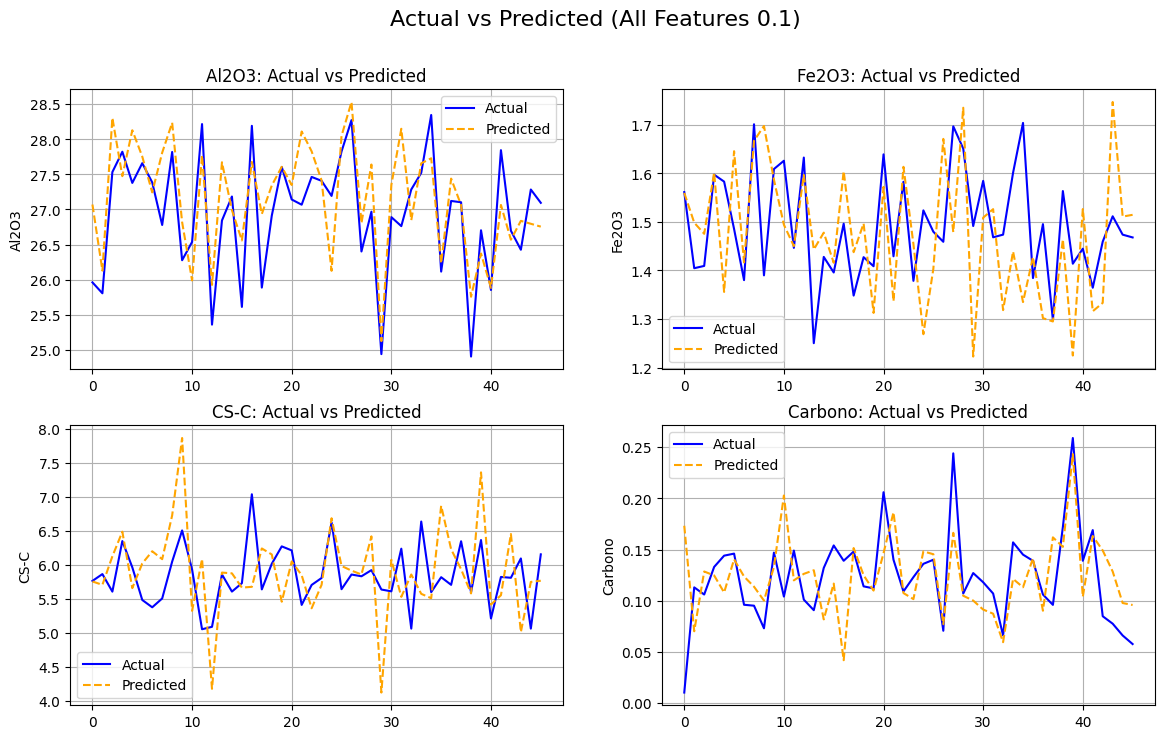

In [100]:
y_targets = ['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']
X = data.drop(columns=y_targets)
y = data[y_targets]

results_df = train_model(X, y, 'All Features 0.1')
all_results.append(results_df)

#### Correlation > 0.2 (Carbono does not have so not trained)

In [101]:
datasets = {}
get_correlated_features(target_columns, 0.2, datasets)
X = {}
y = {}
for target in target_columns:
    X[target] = datasets[target]
    y[target] = data[target]
    print(f"X[{target}]: {X[target].shape}, y[{target}]: {y[target].shape}")

Correlated features for Al2O3.7: ['Al2O3.0', '%.0', 'Al2O3.1', 'A.A..1', 'a.1', '%.1', 'Al2O3.2', 'Fe2O3.2', '>63mm.2', 'CS-C.2', 'L.2', 'CS-C.3', 'RMS.3', 'A.A..3', 'L.3', 'Al2O3.4', 'Fe2O3.4', '>63mm.4', '>45mm.4', 'CS-C.4', 'RMS.4', 'A.A..4', 'Carbono.4', 'L.4', 'a.4', '%.4', 'Al2O3.5', 'Fe2O3.5', '>63mm.5', '>45mm.5', 'RMS.5', 'Carbono.5', 'L.5', '%.5', 'Al2O3.6', 'Fe2O3.6', 'CS-C.6', 'RMS.6', 'A.A..6', 'L.6', '%.6', 'Al2O3.7']
Correlated features for Fe2O3.7: ['>63mm.1', 'RMS.1', 'A.A..1', 'L.1', 'Fe2O3.7', 'CS-C.7']
Correlated features for CS-C.7: ['A.A..3', 'Fe2O3.7', 'CS-C.7']
Correlated features for Carbono.7: ['Carbono.7']
X[Al2O3.7]: (230, 41), y[Al2O3.7]: (230,)
X[Fe2O3.7]: (230, 5), y[Fe2O3.7]: (230,)
X[CS-C.7]: (230, 2), y[CS-C.7]: (230,)
X[Carbono.7]: (230, 0), y[Carbono.7]: (230,)


#### Training using first 3 raw materials and resuls


Training model for target: Al2O3
   MAE: 0.5146
   MSE: 0.4059
   R² Score: 0.4191

Training model for target: Fe2O3
   MAE: 0.1021
   MSE: 0.0154
   R² Score: -0.3478

Training model for target: CS-C
   MAE: 0.3468
   MSE: 0.2095
   R² Score: -0.1275

Training model for target: Carbono
   MAE: 0.0303
   MSE: 0.0017
   R² Score: 0.1124


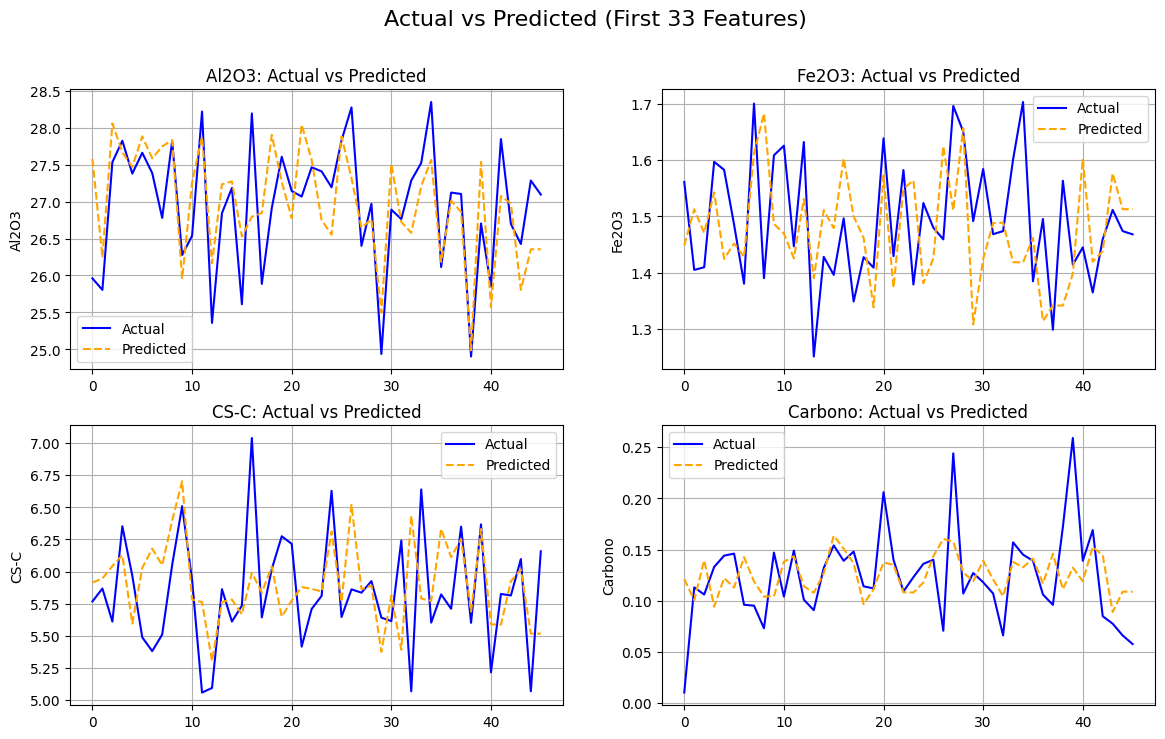

In [102]:
y_targets = ['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']
X = data.iloc[:, :33]
y = data[y_targets]

results_df = train_model(X, y, 'First 33 Features')
all_results.append(results_df)

#### Using only Al to predict Al, Fe to predict Fe and Carbono to predict Carbono

In [103]:
def train_single(X, y, features):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
            'Features': features,  
            'Target': y.name[:-2],
            'MAE': mae,
            'MSE': mse,
            'R2': r2
        })    

    print(f"\nTraining model for target: {y.name[:-2]}")
    print(f"   MAE: {mae:.4f}")
    print(f"   MSE: {mse:.4f}")
    print(f"   R² Score: {r2:.4f}")
    plot_pred(y_test, y_pred)
    
    return pd.DataFrame(results)


Training model for target: Al2O3
   MAE: 0.5727
   MSE: 0.5076
   R² Score: 0.2735


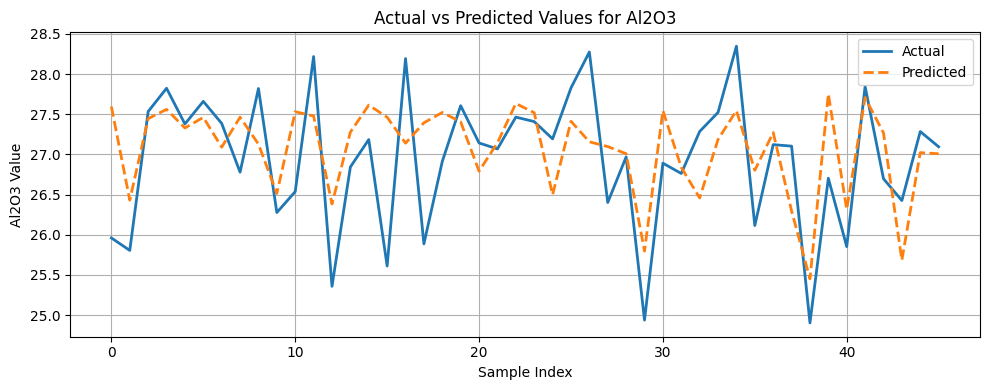

In [104]:
X = data[['Al2O3.0', 'Al2O3.1', 'Al2O3.2', 'Al2O3.3', 'Al2O3.4', 'Al2O3.5', 'Al2O3.6']]
y = data['Al2O3.7']

results_df = train_single(X, y, 'Al2O3 Only')
all_results.append(results_df)


Training model for target: Fe2O3
   MAE: 0.0978
   MSE: 0.0143
   R² Score: -0.2487


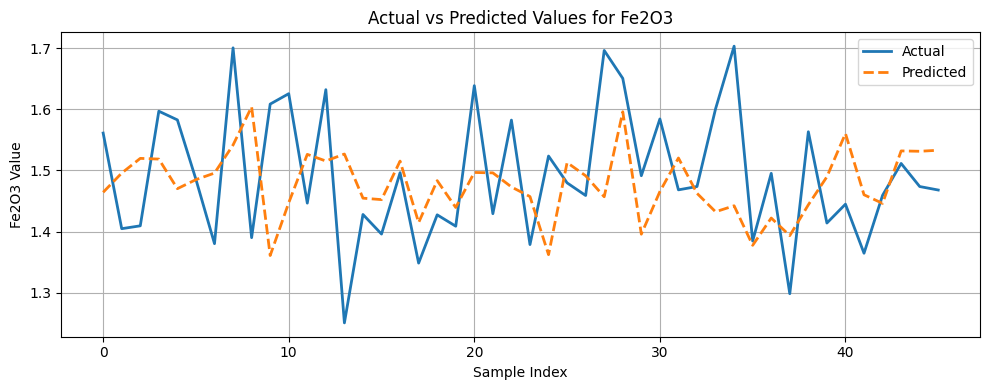

In [105]:
X = data[['Fe2O3.0', 'Fe2O3.1', 'Fe2O3.2', 'Fe2O3.3', 'Fe2O3.4', 'Fe2O3.5', 'Fe2O3.6']]
y = data['Fe2O3.7']

results_df = train_single(X, y, 'Fe2O3 Only')
all_results.append(results_df)


Training model for target: CS-C
   MAE: 0.3438
   MSE: 0.1830
   R² Score: 0.0154


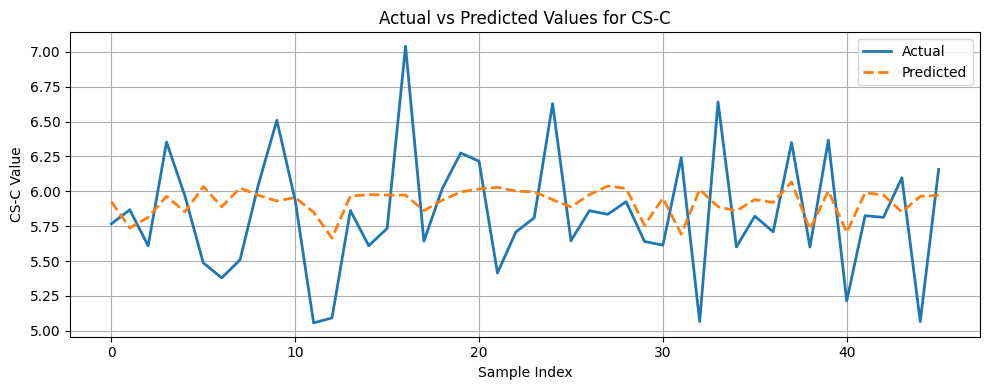

In [106]:
X = data[['CS-C.0', 'CS-C.1', 'CS-C.2', 'CS-C.3', 'CS-C.4', 'CS-C.5', 'CS-C.6']]
y = data['CS-C.7']

results_df = train_single(X, y, 'CS-C Only')
all_results.append(results_df)


Training model for target: Carbono
   MAE: 0.0323
   MSE: 0.0020
   R² Score: -0.0023


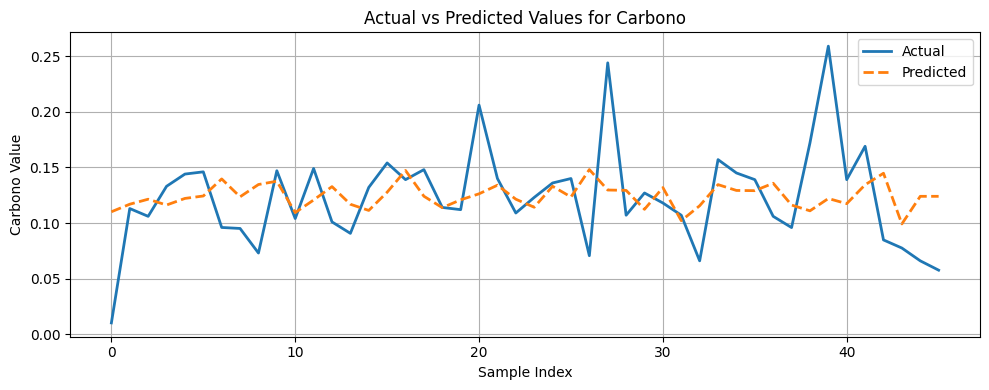

In [107]:
X = data[['Carbono.0', 'Carbono.1', 'Carbono.2', 'Carbono.3', 'Carbono.4', 'Carbono.5', 'Carbono.6']]
y = data['Carbono.7']

results_df = train_single(X, y, 'Carbono Only')	
all_results.append(results_df)

#### Displaying all the results

In [108]:
final_results_df = pd.concat(all_results, ignore_index=True)


print("\nFinal Results:")
from IPython.display import display
display(final_results_df)


Final Results:


,Features,Target,MAE,MSE,R2
0,All Features 0.1,Al2O3,0.486114,0.351496,0.496937
1,All Features 0.1,Fe2O3,0.109827,0.019705,-0.724988
2,All Features 0.1,CS-C,0.518506,0.425968,-1.292261
3,All Features 0.1,Carbono,0.032283,0.001976,-0.013284
4,First 33 Features,Al2O3,0.514595,0.405854,0.419139
5,First 33 Features,Fe2O3,0.102115,0.015396,-0.347790
6,First 33 Features,CS-C,0.346842,0.209531,-0.127547
7,First 33 Features,Carbono,0.030292,0.001731,0.112390
8,Al2O3 Only,Al2O3,0.572654,0.507638,0.273466
9,Fe2O3 Only,Fe2O3,0.097849,0.014264,-0.248736


In [109]:
final_results_df = final_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)
print("\nSorted Final Results:")
display(final_results_df)


Sorted Final Results:


,Features,Target,MAE,MSE,R2
0,All Features 0.1,Al2O3,0.486114,0.351496,0.496937
1,First 33 Features,Al2O3,0.514595,0.405854,0.419139
2,Al2O3 Only,Al2O3,0.572654,0.507638,0.273466
3,First 33 Features,Carbono,0.030292,0.001731,0.112390
4,CS-C Only,CS-C,0.343777,0.182973,0.015371
5,Carbono Only,Carbono,0.032272,0.001955,-0.002301
6,All Features 0.1,Carbono,0.032283,0.001976,-0.013284
7,First 33 Features,CS-C,0.346842,0.209531,-0.127547
8,Fe2O3 Only,Fe2O3,0.097849,0.014264,-0.248736
9,First 33 Features,Fe2O3,0.102115,0.015396,-0.347790
